# Predicting Presidents
### UTK ML, Fall 2020
Building machine learning models to predict results from the 2016 US Presidential election.



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import requests, io

In [31]:
plt.rcParams["figure.figsize"] = (20,10)

In [32]:
train_url = "https://raw.githubusercontent.com/owencqueen/utkML_projects/main/data/train.csv" # Make sure the url is the raw version of the file on GitHub
test_url = "https://raw.githubusercontent.com/owencqueen/utkML_projects/main/data/test.csv"
sample_submission_url = "https://raw.githubusercontent.com/owencqueen/utkML_projects/main/data/sample_submission.csv"
train_download = requests.get(train_url).content
test_download = requests.get(test_url).content
ss_download = requests.get(sample_submission_url).content
# Reading the downloaded content and turning it into a pandas dataframe

train = pd.read_csv(io.StringIO(train_download.decode('utf-8')))
test = pd.read_csv(io.StringIO(test_download.decode('utf-8')))
ss = pd.read_csv(io.StringIO(ss_download.decode('utf-8')))

In [33]:
train

id      State  ST   Fips  ...  total12  other08  other12  Winner
0        0   Illinois  IL  17011  ...  16631.0    313.0    333.0       1
1        1    Georgia  GA  13075  ...   6031.0     46.0     54.0       1
2        2   Michigan  MI  26019  ...   9901.0    171.0    141.0       1
3        3  Louisiana  LA  22091  ...   6394.0     95.0     85.0       0
4        4   Arkansas  AR   5009  ...  15391.0    464.0    460.0       1
...    ...        ...  ..    ...  ...      ...      ...      ...     ...
2638  2638       Ohio  OH  39169  ...  51165.0   1088.0   1106.0       1
2639  2639    Indiana  IN  18129  ...  12226.0    139.0    263.0       1
2640  2640   Virginia  VA  51173  ...  12777.0    246.0    227.0       1
2641  2641   Michigan  MI  26017  ...  53381.0   1044.0    593.0       1
2642  2642      Idaho  ID  16083  ...  28145.0    691.0    831.0       1

[2643 rows x 91 columns]

# Preprocessing and EDA
- There are 90 features (the last one are the labels) and 2643 samples
- some of these values are NaNs
- some of these are percentages (race), ratios (gini coefficient), and others are counts (votes)

In [34]:
train.columns

Index(['id', 'State', 'ST', 'Fips', 'County', 'Precincts', 'Votes',
       'Less Than High School Diploma', 'At Least High School Diploma',
       'At Least Bachelors's Degree', 'Graduate Degree', 'School Enrollment',
       'Median Earnings 2010', 'White (Not Latino) Population',
       'African American Population', 'Native American Population',
       'Asian American Population', 'Other Race or Races', 'Latino Population',
       'Children Under 6 Living in Poverty',
       'Adults 65 and Older Living in Poverty', 'Total Population',
       'Preschool.Enrollment.Ratio.enrolled.ages.3.and.4',
       'Poverty.Rate.below.federal.poverty.threshold', 'Gini.Coefficient',
       'Child.Poverty.living.in.families.below.the.poverty.line',
       'Management.professional.and.related.occupations',
       'Service.occupations', 'Sales.and.office.occupations',
       'Farming.fishing.and.forestry.occupations',
       'Construction.extraction.maintenance.and.repair.occupations',
       'Productio

In [35]:
train['Winner'].value_counts()

1    2230
0     413
Name: Winner, dtype: int64

In [36]:
party = train.groupby('Winner')

In [37]:
party.describe()

id                                ... other12                         
         count         mean         std  min  ...     25%    50%      75%      max
Winner                                        ...                                 
0        413.0  1287.104116  765.782281  3.0  ...   113.0  811.0  3240.50  78831.0
1       2230.0  1327.277578  762.624116  0.0  ...    70.0  160.0   379.75  28786.0

[2 rows x 696 columns]

In [38]:
party.describe()['Gini.Coefficient']

count      mean       std    min      25%    50%    75%    max
Winner                                                                 
0        413.0  0.455562  0.038876  0.339  0.43100  0.458  0.477  0.601
1       2230.0  0.427072  0.034392  0.207  0.40425  0.425  0.448  0.626

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d69096588>,
      dtype=object)

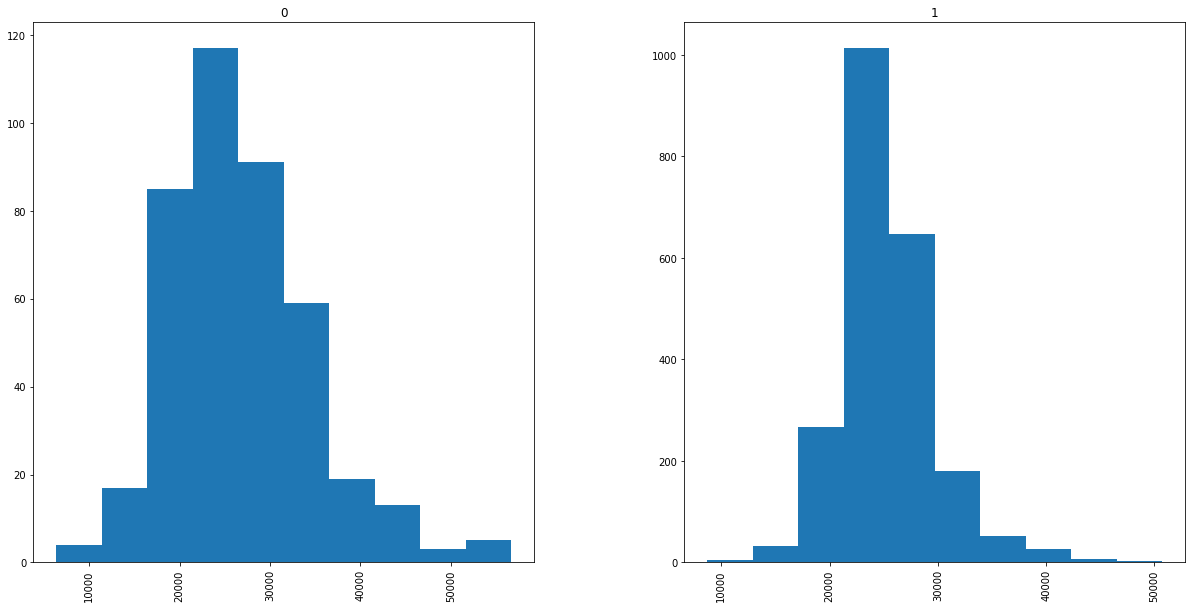

In [39]:
train['Median Earnings 2010'].hist(by=train['Winner'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d68fd1160>,
      dtype=object)

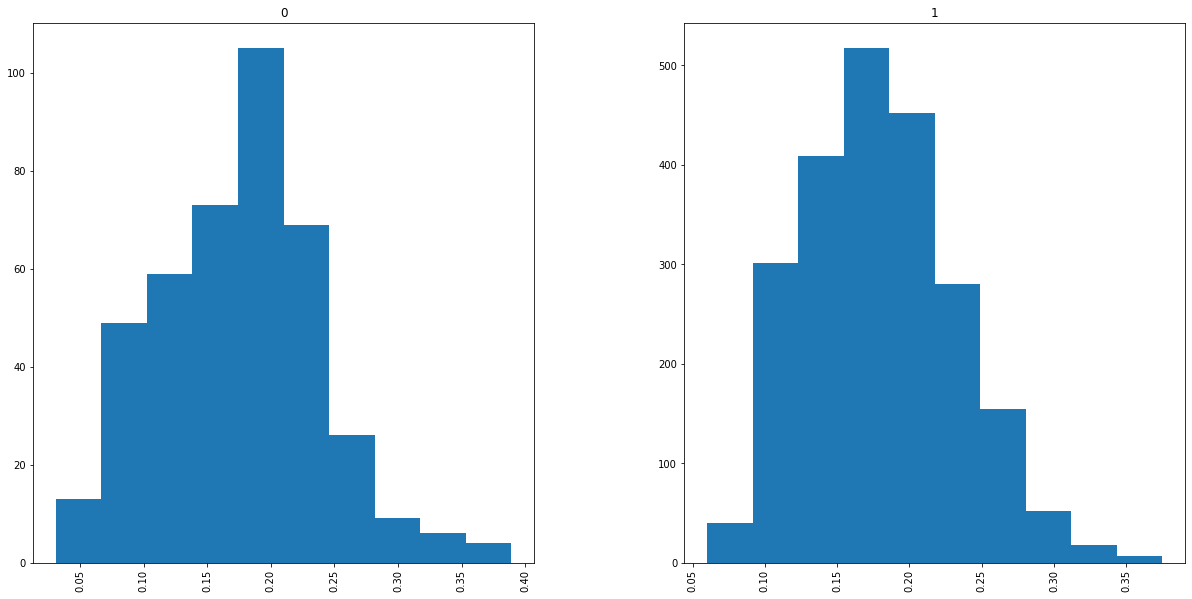

In [40]:
train['Uninsured'].hist(by=train['Winner'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d68f327f0>,
      dtype=object)

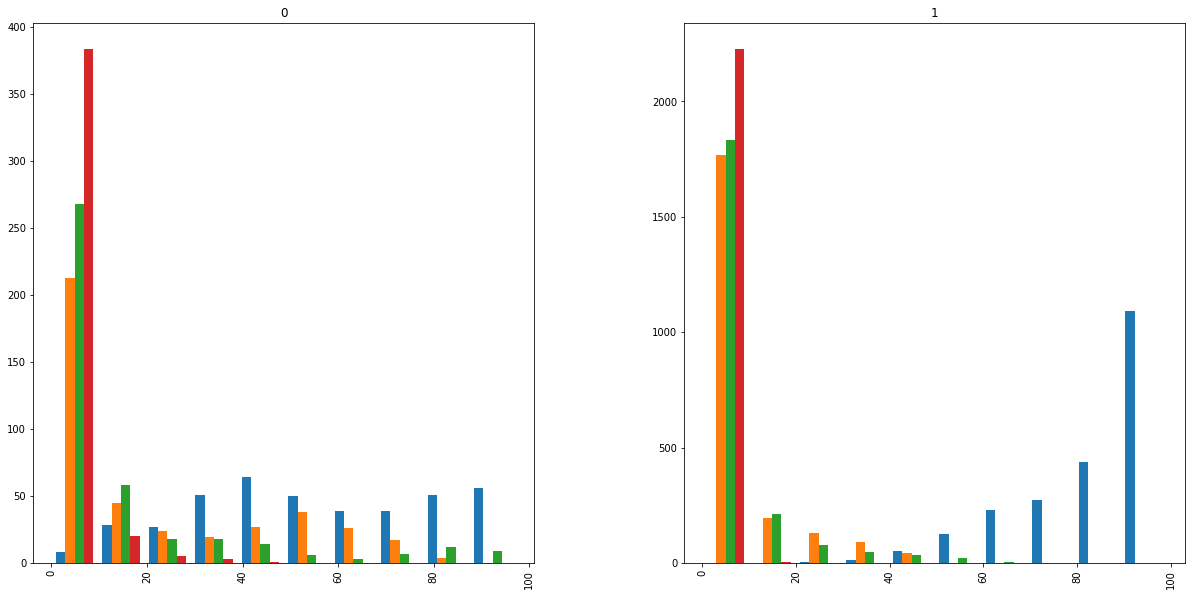

In [41]:
train[['White','Black', 'Hispanic', 'Asian']].hist(by=train['Winner'])

Text(0.5, 1.0, 'gini coefficent per party')

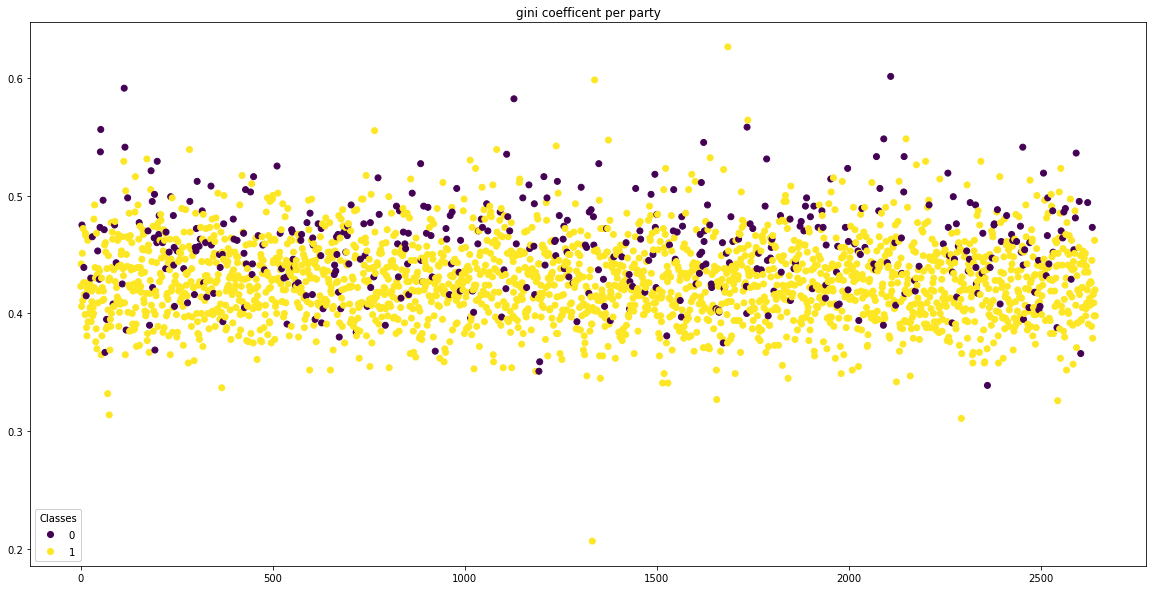

In [42]:
fig, ax = plt.subplots()

scatter = ax.scatter(train['id'], train['Gini.Coefficient'],c=train['Winner'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.title('gini coefficent per party')

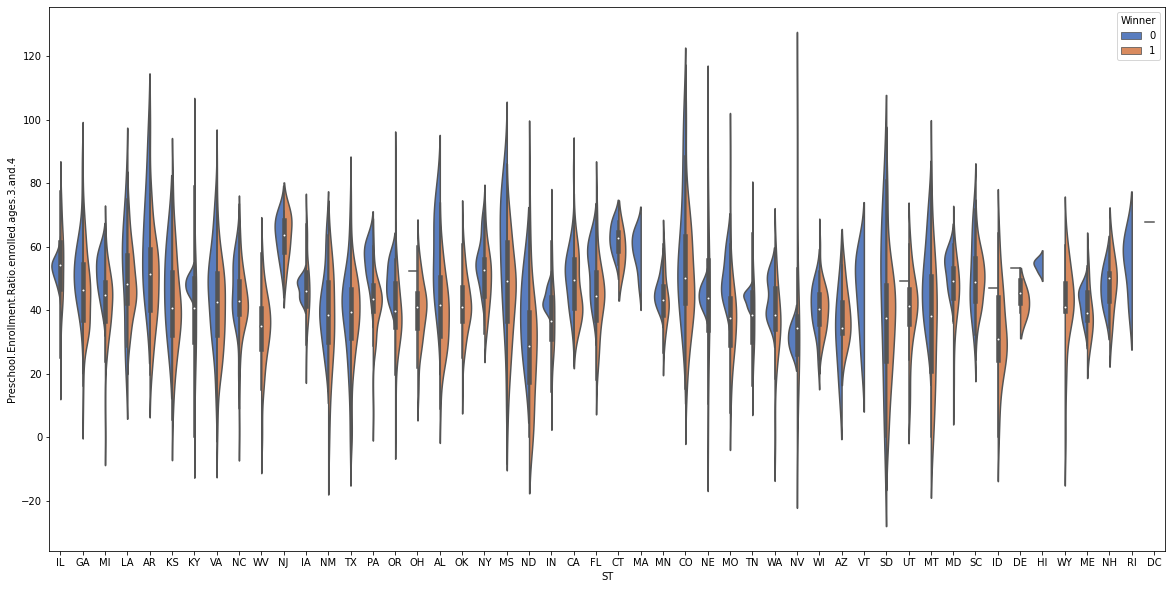

In [43]:
sns.violinplot(x="ST", y="Preschool.Enrollment.Ratio.enrolled.ages.3.and.4", hue="Winner", data=train, palette="muted", split=True)

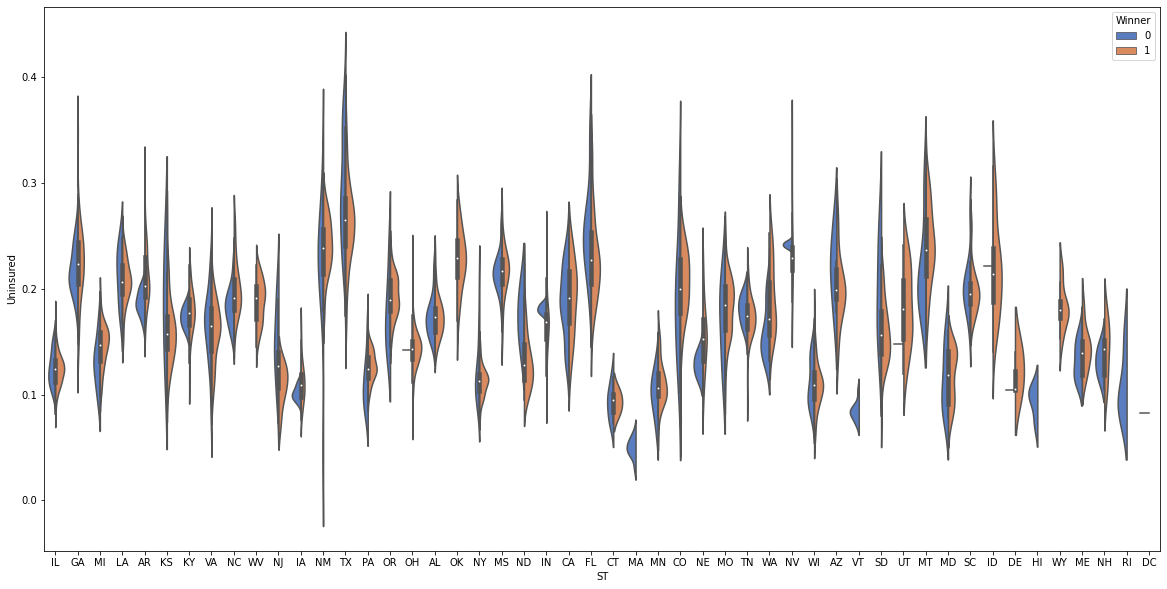

In [44]:
sns.violinplot(x="ST", y="Uninsured", hue="Winner", data=train, palette="muted", split=True)

In [45]:
# Preprocess data:
train.fillna(method = "ffill", inplace = True) # Fill na values
test.fillna(method = "ffill", inplace = True)
    
# 0 = democrats, 1 = republicans

trim = train.iloc[:, 5:] # Leave off the first 5 columns
trim.drop("Winner", axis = 1, inplace = True) # Leave off the last column (labels)
test_trim = test.iloc[:, 5:]

# Fill in NA values
trim.fillna(method = "ffill", inplace = True)
trim.fillna(method = "bfill", inplace = True)

test_trim.fillna(method = "ffill", inplace = True)
test_trim.fillna(method = "bfill", inplace = True)

# Normalize the data:
data = preprocessing.scale(trim)
test_data = preprocessing.scale(test_trim)

#Get labels list:
y = train.loc[:, "Winner"]

x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3)

## kNN Classifier
- Classifying points based on nearest neighbors
- The "neighborhood" determined by how many points you want to consider (k)
- Non-parameterized model: no equation to learn per se
- Computationally expensive

In [46]:
# kNN
model = neighbors.KNeighborsClassifier(n_neighbors = 3)
model.fit(x_train, y_train)

# Verify the model
y_pred = model.predict(x_test)
    
print(metrics.confusion_matrix(y_test, y_pred, labels = [0, 1]))
print("kNN Score:", metrics.accuracy_score(y_test, y_pred))
print("matthews_corrcoef kNN Score:", metrics.matthews_corrcoef(y_test, y_pred))

[[ 84  42]
 [ 22 645]]
kNN Score: 0.9192938209331651
matthews_corrcoef kNN Score: 0.6807521995803576


## Decision Tree
- Decision splits classify data
- Training systematically improves the questions being asked
- Works easily with categorical data; can also work with numerical data (regression trees)

In [47]:
# Decision Tree Classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

y_pred = dt_model.predict(x_test)

print(metrics.confusion_matrix(y_test, y_pred, labels = [0, 1]))
print("Decision Tree Score:", dt_model.score(x_test, y_test))
print("MCC Decision Tree Score:", metrics.matthews_corrcoef(y_test, y_pred))

[[ 88  38]
 [ 37 630]]
Decision Tree Score: 0.905422446406053
MCC Decision Tree Score: 0.6450237282938449


## Random Forest
- Modification of decision trees - more sophisticated
- Algorithm:
    1. Create n random samples of dataset (with replacement)
    2. Train n separate trees
    3. When predicting, predict on all trees, take majority vote
- Variation in the trees produces better results

In [48]:
# Random Forest Classifier
rf_model = RandomForestClassifier(max_depth = 5)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

print(metrics.confusion_matrix(y_test, y_pred, labels = [0, 1]))
print("Random Forest Score:", rf_model.score(x_test, y_test))
print("MCC Random Forest Score:", metrics.matthews_corrcoef(y_test, y_pred))

[[ 83  43]
 [ 14 653]]
Random Forest Score: 0.9281210592686002
MCC Random Forest Score: 0.7115440723458932


In [49]:
ss

id  Winner
0      0       0
1      1       0
2      2       0
3      3       0
4      4       0
..   ...     ...
462  462       0
463  463       0
464  464       0
465  465       0
466  466       0

[467 rows x 2 columns]

In [50]:
#sample submission
sub_pred = rf_model.predict(test_data)
df2 = pd.DataFrame(sub_pred, columns=['Winner'])
submission = pd.concat([test['id'], df2], axis=1)

In [51]:
submission

id  Winner
0      0       1
1      1       0
2      2       1
3      3       1
4      4       1
..   ...     ...
462  462       1
463  463       1
464  464       1
465  465       1
466  466       1

[467 rows x 2 columns]